Now. Let's look at how each parameter affects the step response of the system when compared against the step input test data. This is for water at 600 rpm with 5% step input power.

FLUID DATA FOR step1_10p.csv REFERENCED AT  20-Jun-24 14:35:50:452
###############  step1_10p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 2.21, 2.12, 0.0612]
Ch, Cc, Cf: [2000, 3021, 1100]
###################################################
FLUID DATA FOR step1_50p.csv REFERENCED AT  20-Jun-24 19:01:30:089
###############  step1_50p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 2.21, 2.12, 0.0612]
Ch, Cc, Cf: [2000, 3021, 1100]
###################################################
FLUID DATA FOR step_5p.csv REFERENCED AT  19-Jun-24 15:45:47:206
uh oh... something went horribly wrong! at dates (datetime.datetime(2024, 6, 19, 15, 55, 20, 609), datetime.datetime(2024, 6, 19, 15, 51, 27, 233))
uh oh... something went horribly wrong! at dates (datetime.datetime(2024, 6, 19, 23, 28, 25, 202), datetime.datetime(2024, 6, 19, 23, 19, 55, 168))
###############  step_5p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 2.21, 2.12, 0.0612]
Ch, Cc, Cf: [2000, 3021, 1100]
############################

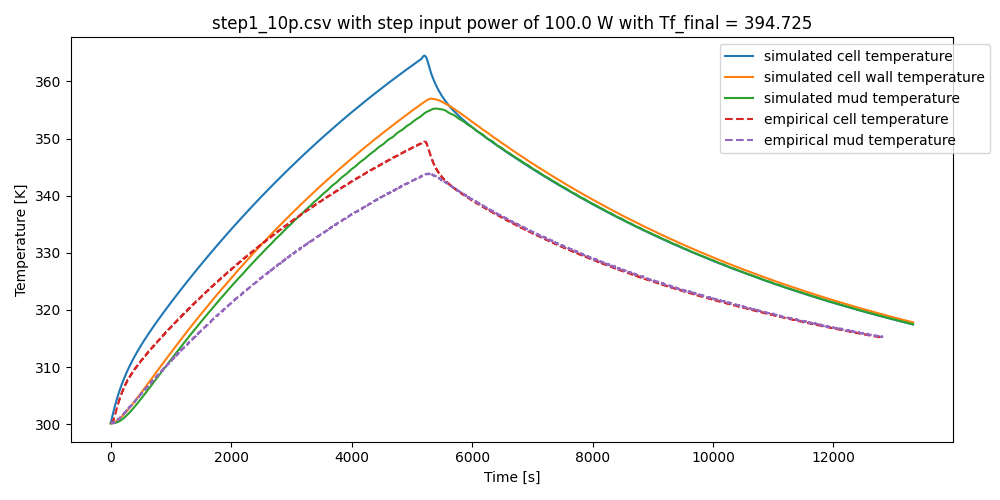

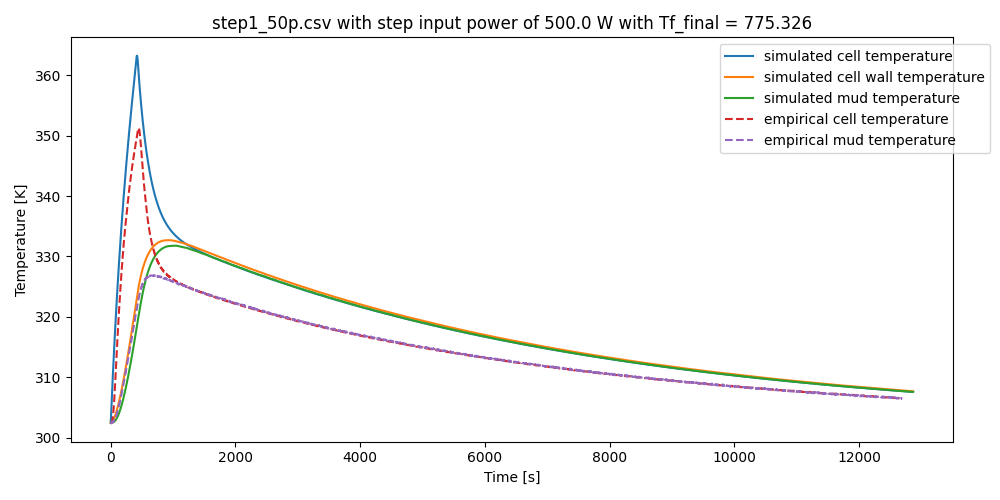

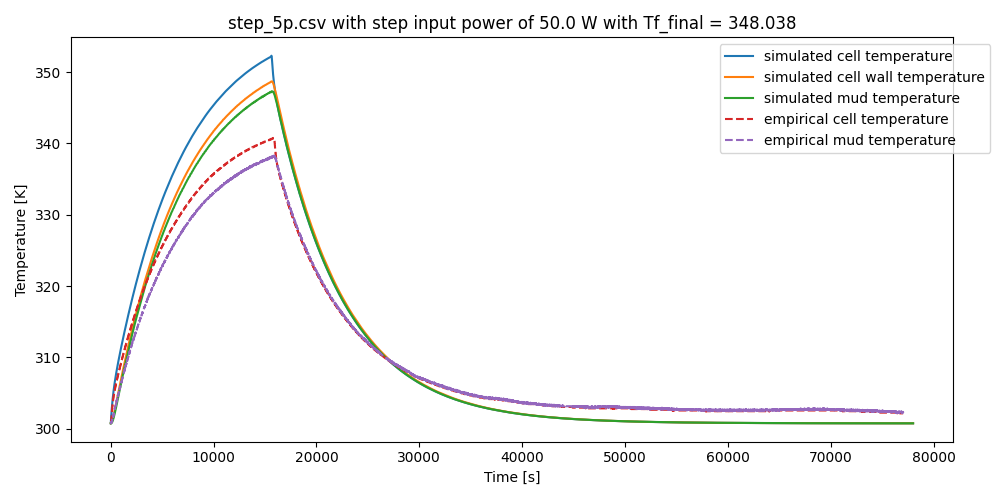

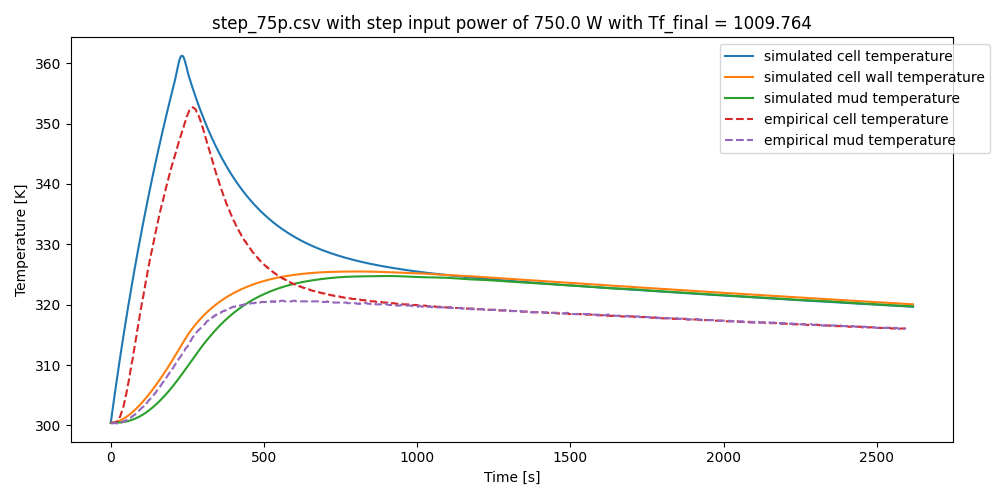

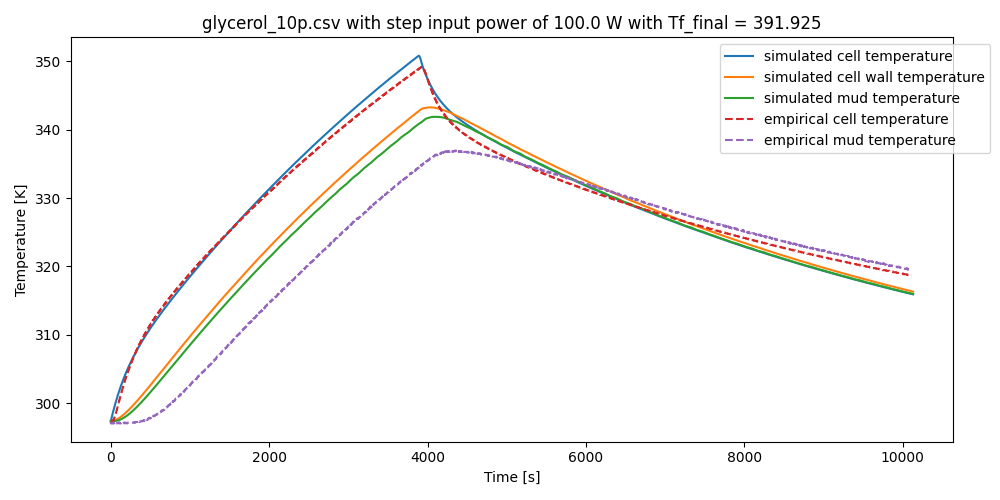

In [1]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["step1_10p.csv", "step1_50p.csv", "step_5p.csv", "step_75p.csv", "glycerol_10p.csv"]:
    step_power = float(filename.split('p')[-2].split('_')[-1])/100
    my_fluid = MysteriousMud(filename)
    my_fluid.importRawData(filename, heaterHeader=True)

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rj,Rfj,Rf]
    # self.thermal_capacitances = [Cc, Cf]

    model.thermal_resistances = [.14, 2.210, 2.12, .0612] # Rf
    model.thermal_capacitances = [2000, 3021, 1100]
    #model.Tambient = 302.5

    x0 = np.array([1,1,1]) *  model.Tambient
    temp_cell, temp_mud = model.stepResponse(x0, powerPercentage = step_power)
    model.plot()

Let's test on a 3rd order model.

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

Ch = 1000 #cap_ss * density_ss * d_heat**2 /4 * np.pi * l_heat * n_heaters
Rc = .1
Rj = 10
Cc = 6000
Cf = 1200
Rf = 0.1
Rfj = 5


Tn = 1500


def ss_model(t,x): # x = [Th-Tamb, Tc-Tamb; Tf-Tamb]

        A = np.array([[-1/Ch * (1/Rc + 1/Rj), 1/(Rc*Ch), 0],
                [1/(Rc*Cc), -1/Cc * (1/Rc + 1/Rf), 1/(Rf*Cc)],
                [0, 1/(Rf*Cf), -1/Cf * (1/Rfj + 1/Rf)]])
        B = np.array([1/Ch, 0, 0]).transpose() 
        C = np.array([0, 0, 1])

        if t > 0 and t < Tn/3:
            p = 100
        else:
            p = 0
        
        d = 0
        if p > 0:
            p = min(abs(p),1000)
        else:
            p = 0

        xdot = A @ x + B*p + d

        #print(x.shape, xdot)
        return xdot

Tambient = 300
tvec = np.linspace(0,Tn,1000)
X0 = np.zeros(3)
sol = solve_ivp(ss_model,(tvec[0],tvec[-1]), X0, t_eval=tvec)

yout = sol.y
temp_mud = yout[2,:] + Tambient
temp_cell = yout[1,:] + Tambient
temp_heater = yout[0,:] + Tambient



plt.figure()
plt.plot(tvec,temp_heater, label = "heater temp")
plt.plot(tvec,temp_cell, label = "cell temp")
plt.plot(tvec,temp_mud, label = "mud temp")

plt.legend()

Looks a lot better!

FLUID DATA FOR calibration_fluid_50p.csv REFERENCED AT  01-Jul-24 15:27:17:848
###############  calibration_fluid_50p.csv   ################
Rc, Rj, Rfj, Rf: [0.14, 2.21, 2.02, 0.0095]
Ch, Cc, Cf: [2000, 3000, 400]
###################################################
water_50p.csv file not found!


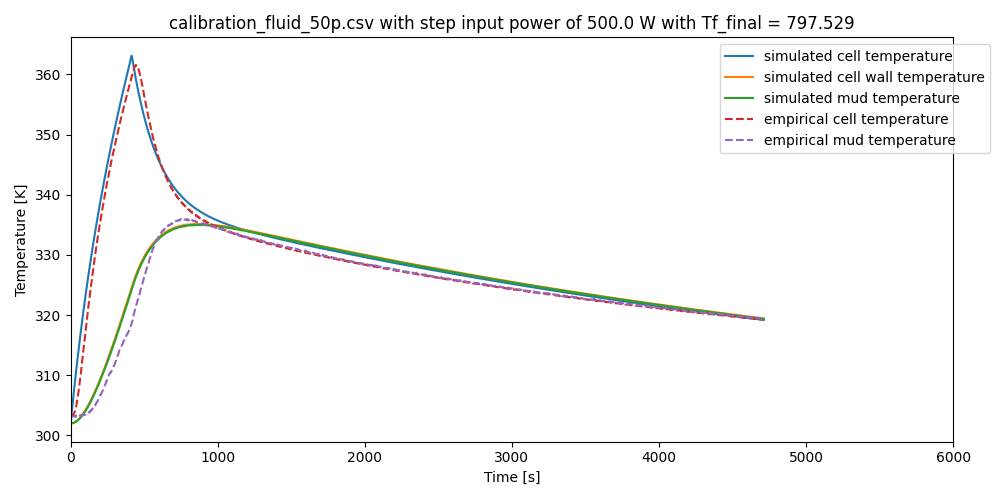

In [25]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["calibration_fluid_50p.csv","water_50p.csv"]:

    step_power = float(filename.split('p')[-2].split('_')[-1])/100
    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.14, 2.210, 2.02, .0095] # Rf
    model.thermal_capacitances = [2000, 3000, 400]
    model.Tambient = 302

    x0 = np.array([1,1,1]) * model.Tambient
    temp_cell, temp_mud = model.stepResponse(x0, powerPercentage = step_power)
    model.plot()
    plt.xlim([0,6000])
 